<a href="https://colab.research.google.com/github/jwgdmkj/jupiterColab/blob/master/Chap2_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df_train = pd.read_csv('train.csv')
df_train["LotShape"]

0       Reg
1       Reg
2       IR1
3       IR1
4       IR1
       ... 
1455    Reg
1456    Reg
1457    Reg
1458    Reg
1459    Reg
Name: LotShape, Length: 1460, dtype: object

In [20]:
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,G

In [21]:
# Missing Data
# isnull : null값을 보이는 칼럼들(TRUE, FALSE로 나눠지는 것들)을 한데 모은다.
# 여기에서, sum()은 각 칼럼의 true값을 반환한다. 즉, 예를 들어 PoolQC는 True가 1453개 있다.
df_missing = df_train.isnull().sum() 
df_missing = df_missing.sort_values(ascending = False) #df_missing
df_missing

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
                 ... 
CentralAir          0
SaleCondition       0
Heating             0
TotalBsmtSF         0
Id                  0
Length: 81, dtype: int64

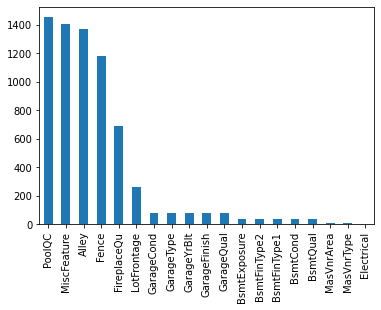

In [22]:
df_missing[df_missing >  0].plot.bar()

In [23]:
#missing data가 있는 feature 제거
df_missing = df_missing[df_missing > 0] #df_missing 중에, 0 이상의 값을 갖는 것들을 따로 배열로 만든다.
df_train = df_train.drop(df_missing.index.tolist(), axis = 1) #axis = 1 : 열로 보여줌(0은 행)
#df_train 내에서, missing을 제거한다.

df_train.isnull().sum().max()

0

In [24]:
numeric = [f for f in df_train.columns if df_train.dtypes[f] != 'object'] 
#숫자형. for i in v : if i == 12 // i for i in v if i == 12 
# df_trains.columns 내에서, 해당 df_train의 type이 object가 아닌것들(숫자인것들만) 따로 저장.
numeric.remove('Id')
numeric.remove('SalePrice')

categorical = [f for f in df_train.columns if df_train.dtypes[f] == 'object'] #분류형인것만 따로 저장

#SaleCondition, SalePrice 칼럼을 따로 떼서 행렬로 생성.
#이를, SaleCondition을 기준으로 SalePrice를 평균을 낸다.
#df_train[['SaleCondition', 'SalePrice']].groupby('SaleCondition').mean()['SalePrice']

**Preprocess Categorical Data**

In [25]:
category_maps = []

def add_rank_feature(feature_name, rank_feature_name) :
  df_order = pd.DataFrame() #수집 데이터 분석용 패키지(DataFrame)
  df_order['val'] = df_train[feature_name].unique() #받은 df_train의 feature_name 칼럼의 unique한 값만을 담음
  df_order.index = df_order.val

  #mean_price라는 칼럼을 새로 만들고, 여기에 feature_name, SalePrice를 결합시킨다음(feature_name, salePrice의 리스트)
  #feature_name으로 그룹을 맺은 다음, 평균값을 구한다.
  #feature_name을 기준으로 묶어서 평균값을 내도, matrix가 나온다. 이 때,
  #saleprice 칼럼의 mean값을 구하는 것이다. 즉, 이것이 없으면 행렬만 구해진다.

  #'mean_price'라는 칼럼은, feature_name과 salePrice 칼럼의 리스트들을 feature_name을 기준으로 묶어놓은 다음,
  # mean처리를 한 데이터의 'saleprice'칼럼이다.
  # rank는, 이 만들어진 df_order의 +1만큼의 길이를 가지고 있다. 즉, feature_name의 size만큼의 크기다.
  # 이를 to_dict화 시킨다.

  # 즉, 어떠한 feature과 price의 상관관계를 밝히고자 한다. 해당 feature을 그룹으로 묶은 다음, saleprice의 mean을 따짐
  # rank 배열을 하나 만들고, to_dict 시킨다.
  df_order['mean_price'] = df_train[[feature_name, 'SalePrice']].groupby(feature_name).mean()['SalePrice']
  df_order['rank'] = range(1, len(df_order) + 1)
  df_order = df_order['rank'].to_dict()

  # 이를 category_maps에 추가시킨다.
  category_maps.append(df_order)

  # df_train[rank_feature_name]은, df_order의 'feature_name' 칼럼이 된다.
  df_train[rank_feature_name] = df_train.apply(lambda x : df_order[x[feature_name]], axis = 1)

In [26]:
rank_features = []

#분류형으로만 된 칼럼의 행렬들에, 그 각칼럼+_rank 문자열 새이름을,
#그 칼럼 이름+새이름으로 add_rank 시킨다음에, rank_features에 append시킨다.
for feature_name in categorical :
  rank_feature_name = feature_name + '_rank'

  #print(feature_name. '-->', rank_feature_name)
  add_rank_feature(feature_name, rank_feature_name)
  rank_features.append(rank_feature_name)

df_train

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterQual_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,706,0,150,856,GasA,Ex,Y,856,854,0,1710,1,0,2,...,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,978,0,284,1262,GasA,Ex,Y,1262,0,0,1262,0,1,2,...,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,1,1,1,1,1,2,1,2,2,1,1,2,1,1,2,2,2,1,2,1,1,1,2,1,1,1,1
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,486,0,434,920,GasA,Ex,Y,920,866,0,1786,1,0,2,...,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,BrkTil,216,0,540,756,GasA,Gd,Y,961,756,0,1717,1,0,1,...,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,1,1,2,1,1,3,1,3,1,1,1,1,1,1,3,3,2,1,3,1,2,1,1,1,1,1,2
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,655,0,490,1145,GasA,Ex,Y,1145,1053,0,2198,1,0,2,...,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,1,1,2,1,1,2,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,0,0,953,953,GasA,Ex,Y,953,694,0,1647,0,0,2,...,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000,1,1,1,1,1,1,1,18,1,1,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,1,1
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,TA,TA,CBlock,790,163,589,1542,GasA,TA,Y,2073,0,0,2073,1,0,2,...,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000,1,1,1,1,1,1,1,7,1,1,1,2,1,1,8,5,2,1,2,1,3,1,2,2,1,1,1
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,Ex,Gd,Stone,275,0,877,1152,GasA,Ex,Y,1188,1152,0,2340,0,0,2,...,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500,1,1,1,1,1,1,1,3,1,1,1,1,1,1,7,7,3,2,6,1,1,1,1,1,1,1,1
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,TA,TA,CBlock,49,1029,0,1078,GasA,Gd,Y,1078,0,0,1078,1,0,1,...,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125,1,1,1,1,1,1,1,12,1,1,1,2,2,1,2,2,2,1,2,1,2,1,1,1,1,1,1


In [27]:
df_processed = df_train[rank_features + numeric]
df_processed['SalePrice'] = df_train['SalePrice']
df_processed #이를 통해, 오직 숫자로만 구성된(+가격) 칼럼이 완성됨

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterQual_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,1,1,1,1,1,2,1,2,2,1,1,2,1,1,2,2,2,1,2,1,1,1,2,1,1,1,1,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007,181500
2,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,223500
3,1,1,2,1,1,3,1,3,1,1,1,1,1,1,3,3,2,1,3,1,2,1,1,1,1,1,2,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006,140000
4,1,1,2,1,1,2,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1,1,1,1,1,1,1,18,1,1,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,1,1,60,7917,6,5,1999,2000,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,2,460,0,40,0,0,0,0,0,8,2007,175000
1456,1,1,1,1,1,1,1,7,1,1,1,2,1,1,8,5,2,1,2,1,3,1,2,2,1,1,1,20,13175,6,6,1978,1988,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,2,500,349,0,0,0,0,0,0,2,2010,210000
1457,1,1,1,1,1,1,1,3,1,1,1,1,1,1,7,7,3,2,6,1,1,1,1,1,1,1,1,70,9042,7,9,1941,2006,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1,252,0,60,0,0,0,0,2500,5,2010,266500
1458,1,1,1,1,1,1,1,12,1,1,1,2,2,1,2,2,2,1,2,1,2,1,1,1,1,1,1,20,9717,5,6,1950,1996,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1,240,366,0,112,0,0,0,0,4,2010,142125


In [28]:
"""
dataframe=pd.DataFrame({'Attendance': {0: 60, 1: 100, 2: 80,3: 78,4: 95},
                        'Name': {0: 'Olivia', 1: 'John', 2: 'Laura',3: 'Ben',4: 'Kevin'},
                        'Obtained Marks': {0: 90, 1: 75, 2: 82, 3: 64, 4: 45}})
print("The Original Data frame is: \n")
print(dataframe)

dataframe1 = dataframe.corr()
print("The Correlation Matrix is: \n")
print(dataframe1)

The Original Data frame is: 

   Attendance    Name  Obtained Marks
0          60  Olivia              90
1         100    John              75
2          80   Laura              82
3          78     Ben              64
4          95   Kevin              45
The Correlation Matrix is: 

                Attendance  Obtained Marks
Attendance         1.00000        -0.61515
Obtained Marks    -0.61515         1.00000
"""
corrmat = df_processed.corr() # corr : 그룹 별 변수간 상관관계 분석
corrmat

,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterQual_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSZoning_rank,1.000000,0.039678,-0.167918,-0.013396,-0.011167,-0.094747,-0.043444,-0.067889,-0.026021,0.016014,0.271750,-0.047199,-0.088537,-0.049864,-0.063732,-0.025637,-0.018093,0.017808,0.011181,0.012889,-0.035643,0.144970,-0.030523,-0.029668,0.117402,0.058948,0.068705,0.286937,-0.161640,-0.015122,-0.026962,-0.062684,0.033050,-0.150204,-0.086788,0.012159,-0.175826,-0.227642,0.119662,0.074114,-0.061209,-0.111509,-0.070463,0.011160,0.014871,-0.085901,0.073459,-0.089983,-0.194000,-0.077273,-0.057814,-0.133311,0.109211,0.075025,-0.045145,-0.067541,-0.029301,-0.021573,0.022231,-0.010621,-0.116047
Street_rank,0.039678,1.000000,0.010129,0.097236,-0.001682,0.004458,0.179360,0.053445,0.023914,-0.005881,0.023392,0.025328,0.006881,-0.007749,0.011874,0.015314,0.143047,0.002633,0.021128,-0.008194,0.043211,0.069869,0.055746,-0.015465,0.011248,0.021171,0.022919,0.024969,0.197131,-0.058823,-0.042848,-0.021137,-0.065465,0.015643,0.038487,-0.035229,-0.005068,-0.005950,-0.046983,-0.007724,-0.044121,0.050524,-0.015485,-0.046471,-0.027628,-0.028865,-0.013583,-0.046828,0.005348,0.020025,0.047794,0.017990,0.005664,-0.023082,-0.007473,0.033160,-0.004413,0.022733,-0.003690,0.025043,-0.041036
LotShape_rank,-0.167918,0.010129,1.000000,0.201047,0.026616,0.308073,0.144248,-0.013295,0.066612,0.052183,-0.134373,-0.067647,0.043063,0.118271,-0.030630,-0.068168,-0.111502,-0.047015,-0.158779,-0.043320,-0.119556,-0.099138,-0.089061,-0.017841,-0.100666,0.001435,-0.004773,-0.115361,0.315484,0.198994,-0.033747,0.229365,0.175488,0.157718,0.060419,0.014179,0.200469,0.189251,0.089380,-0.007973,0.212741,0.064638,0.057729,0.184213,0.116576,0.060028,-0.094870,0.137148,0.202019,0.194984,0.173472,0.161717,0.093135,-0.095092,0.033801,0.065182,0.047100,0.028638,0.026617,-0.037391,0.267759
LandContour_rank,-0.013396,0.097236,0.201047,1.000000,-0.007963,0.021107,0.507203,0.113336,-0.021478,0.012096,-0.042667,-0.004987,0.100625,0.109717,0.034502,0.014566,0.075493,0.001553,-0.000145,-0.024849,0.028243,0.023605,0.037246,0.016088,0.081031,-0.014537,0.062826,-0.018947,0.258792,0.039133,0.000986,-0.029314,-0.007847,0.078115,0.000817,-0.025046,0.056286,0.069659,0.004182,0.013466,0.055967,0.061263,0.029524,-0.003962,-0.019361,-0.022162,0.013208,0.021954,0.091564,0.049099,0.040419,0.072820,-0.045007,-0.002514,0.048478,0.003305,-0.008139,-0.014892,0.063280,-0.026117,0.092009
Utilities_rank,-0.011167,-0.001682,0.026616,-0.007963,1.000000,0.062298,-0.005909,0.029258,-0.008311,-0.002397,-0.010899,0.076219,-0.011462,-0.003158,0.008321,0.004602,0.012733,-0.008842,0.008611,-0.003339,0.003963,-0.006907,-0.026715,-0.006303,-0.007368,0.057455,0.019173,-0.022844,0.010123,-0.001881,0.009994,-0.011505,-0.034080,-0.019100,0.049913,-0.012639,-0.014233,0.012287,-0.020818,-0.003148,-0.008545,-0.021467,0.103380,-0.026862,-0.019939,0.004288,-0.005536,0.007769,0.015721,0.008161,0.006372,-0.019692,0.028199,-0.009407,-0.003046,0.102365,-0.001798,-0.002296,-0.051552,0.023353,-0.014314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PoolAre

In [29]:
#f, ax = plt.subplots(figsize=(24, 18))
#sns.heatmap(corrmat, vmax=.8, square=True);

#corrmat을, SalePrice를 기준으로 오름차순 정렬한다.
#즉, SalePrice가 가장 낮은 feature부터 보여주는데,
#맨 마지막의 ['SalePrice']는, 그 행렬의 SalePrice 칼럼만을 보여준다.
df_features = corrmat.sort_values(by = ['SalePrice'])['SalePrice']
df_features[:-1]
#df_features

Foundation_rank      -0.429678
HeatingQC_rank       -0.427649
ExterQual_rank       -0.265015
CentralAir_rank      -0.251328
PavedDrive_rank      -0.208954
HouseStyle_rank      -0.188688
Exterior2nd_rank     -0.164716
Neighborhood_rank    -0.143621
KitchenAbvGr         -0.135907
EnclosedPorch        -0.128578
ExterCond_rank       -0.121706
Exterior1st_rank     -0.120586
MSZoning_rank        -0.116047
KitchenQual_rank     -0.114746
BldgType_rank        -0.112611
Functional_rank      -0.108367
Heating_rank         -0.106673
MSSubClass           -0.084284
OverallCond          -0.077856
Condition1_rank      -0.044820
Street_rank          -0.041036
YrSold               -0.028923
LowQualFinSF         -0.025606
MiscVal              -0.021190
BsmtHalfBath         -0.016844
Utilities_rank       -0.014314
BsmtFinSF2           -0.011378
Condition2_rank      -0.004833
RoofMatl_rank         0.035820
3SsnPorch             0.044584
MoSold                0.046432
LandSlope_rank        0.051152
SaleType

**X, Y DATA**

In [30]:
# K-fold cross validation : Data가 작을 때 validation accuracy를 믿고자 하면

NUM_FEATURES = len(df_features) - 1
#print(NUM_FEATURES) #60

# 우선, df_features의 인덱스(맨 왼쪽의, 기준이 되는 것들)을 list화 시킨다.
# df_processed는, SalePrice나 Foundation_rank 등을 통해 이를 수치화시킨 칼럼에의 접근
# 이 가능한 상태다.따라서, 이러한 인덱스의 리스트를 []안에 집어넣으면
# 모든 df_feature에 대한 df_processed 내의 값(수치화된 것들)에의 접근이 가능.
X = df_processed[df_features[-NUM_FEATURES-1 : -1].index.tolist()]
y = df_processed['SalePrice']
y = np.array(y).reshape(-1, 1) #현재 y는 SalePrice만 가지고 있는 1차원이다.
#따라서, reshape(-1, 1)을 통해 각 요소가 배열이 되는 (1460*1)의 2차원으로 만들어준다.
X.shape, y.shape

((1460, 60), (1460, 1))

In [31]:
#X를 csv파일로 저장

X.to_csv('X.csv', index = False)

# numpy 데이터 저장
with open('X.npy', 'wb') as f:
  np.save(f, X)
with open('y.npy', 'wb') as f:
  np.save(f, y)

# load numpy data
with open('X.npy', 'rb') as f:
    X = np.load(f)

with open('y.npy', 'rb') as f:
    y = np.load(f)

In [32]:
x_min_max_scaler = MinMaxScaler() #데이터를 0~1 사이로 줄여주는 함수
x_min_max_scaler.fit(X)
scaled_X = x_min_max_scaler.transform(X) #피팅시키고, 스케일링

y_min_max_scaler = MinMaxScaler()
y_min_max_scaler.fit(y)
scaled_y = y_min_max_scaler.transform(y)

In [33]:
# K-fold cross validation
#초기는, 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, 
#randoma_state =42)
#처럼, test_size를 0.1로 10% 잘라서 테스트를 하였다

#데이터를 쪼개서, 10%로 자르되, 서로 다른 test set을 만들어보자
#각 test set에는, 146개가 들어가게 됨

K = 10
data_size = int(len(X)/K)
data_size

146

In [34]:
#이젠, 이 10조각을 한 번씩 트레이닝 해야 함
#즉, 테스트셋을 초기화해가며, 바꿔나가 학습시켜야 함

kf = KFold(n_splits=K)

X

array([[   1,    1,    1, ...,    2, 1710,    7],
       [   2,    1,    2, ...,    2, 1262,    6],
       [   1,    1,    1, ...,    2, 1786,    7],
       ...,
       [   6,    1,    3, ...,    1, 2340,    7],
       [   2,    2,    2, ...,    1, 1078,    5],
       [   2,    2,    1, ...,    1, 1256,    5]])

** Linear Regression **

In [35]:
rmses = []

#선형회귀
for train_index, test_index in kf.split(scaled_X) :
  
  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  #training
  model = Lasso()
  model = model.fit(scaled_X_train, scaled_y_train)

  #evaluation
  pred = model.predict(scaled_X_test).reshape((-1, 1))
  pred = y_min_max_scaler.inverse_transform(pred) #원상복구 된 스케일
  
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print("--------------------")

  rmses.append(rmse)
print("average rmse : ", np.mean(rmses))

68479.61848137801
--------------------
80011.92820033105
--------------------
79275.65958882873
--------------------
82868.15912800275
--------------------
96386.20490927555
--------------------
76808.56629102639
--------------------
72198.44861652121
--------------------
71213.04254017191
--------------------
90347.61467595294
--------------------
72613.27897372228
--------------------
average rmse :  79020.25214052107


**MLP**

In [40]:
rmses = []

for train_index, test_index in kf.split(scaled_X) :
  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  #training
  model= keras.Sequential(
      [
       keras.Input(shape = scaled_X_train.shape[-1]),
       layers.Dense(96, activation = 'relu'),
       layers.Dense(48, activation = 'relu'),
       layers.Dense(1)
       ]
  )

  model.compile(loss = "mse", optimizer = "adam")

  early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                             patience = 7)
  model.fit(scaled_X_train, scaled_y_train, batch_size=4, epochs=150, 
            callbacks = [early_stopping_callback], validation_split=0.05)
  
  #evaluation
  pred = model.predict(scaled_X_test).reshape((-1,1))
  pred = y_min_max_scaler.inverse_transform(pred) #원상복구 된 스케일
  
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print("--------------------")

  rmses.append(rmse)

print("average rmse : ", np.mean(rmses))

Epoch 1/150
312/312 [==============================] - 2s 3ms/step - loss: 0.0250 - val_loss: 0.0027
Epoch 2/150
312/312 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 3/150
312/312 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 4/150
312/312 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 5/150
312/312 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 6/150
312/312 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 7/150
312/312 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/150
312/312 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/150
312/312 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/150
312/312 [==============================] - 1s 2ms/step - loss: 0.0018 - val_lo

**Decision Tree**

In [41]:
from sklearn.tree import DecisionTreeRegressor

rmses = []

for train_index, test_index in kf.split(scaled_X):
  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  # training
  model = DecisionTreeRegressor(random_state=0)
  model = model.fit(scaled_X_train, scaled_y_train)

  # evaluation
  pred = model.predict(scaled_X_test).reshape((-1, 1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print("---------------------")
  
  rmses.append(rmse)

print("average rmse:", np.mean(rmses))

33991.748088967644
---------------------
44798.358468809995
---------------------
30699.46326702735
---------------------
42051.71372829295
---------------------
41213.62745251285
---------------------
33617.36360218694
---------------------
30677.817384990885
---------------------
34381.51839228314
---------------------
71324.15999548571
---------------------
36009.24070034063
---------------------
average rmse: 39876.501108089804


**Random Forest**

In [42]:
from sklearn.ensemble import RandomForestRegressor

rmses = []
for train_index, test_index in kf.split(scaled_X):
  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  # training
  model = RandomForestRegressor(random_state = 0, n_estimators = 100)
  model = model.fit(scaled_X_train, scaled_y_train)

  # evaluation
  pred = model.predict(scaled_X_test).reshape((-1, 1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print("---------------------")
  
  rmses.append(rmse)

print("average rmse:", np.mean(rmses))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


24981.71784432939
---------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


26859.392784461328
---------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


21738.09954310842
---------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


40185.418338737254
---------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


33108.127783048876
---------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


26837.920286714
---------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


25039.448716371728
---------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


22974.66120282157
---------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


42278.95395646975
---------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


27108.528627471893
---------------------
average rmse: 29111.226908353427


**Ada Boost**

In [43]:
from sklearn.ensemble import AdaBoostRegressor

rmse = []
for train_index, test_index in kf.split(scaled_X):
  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  # training
  model = AdaBoostRegressor(random_state = 0)
  model = model.fit(scaled_X_train, scaled_y_train)

  # evaluation
  pred = model.predict(scaled_X_test).reshape((-1, 1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print("---------------------")
  
  rmses.append(rmse)

print("average rmse:", np.mean(rmses))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


29216.343827541197
---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


33282.117102484
---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


29149.232825948846
---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


44189.177644650124
---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


39012.2510911128
---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


33095.41790740461
---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


31417.10861322294
---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


30933.03236129543
---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


46328.51256772787
---------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


34212.22304763838
---------------------
average rmse: 32097.38430362802


**XGBoost**

In [44]:
rmses = []

for train_index, test_index in kf.split(scaled_X) :
  
  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  #training
  model = XGBRegressor(n_estimators = 300)
  model = model.fit(scaled_X_train, scaled_y_train)

  #evaluation
  pred = model.predict(scaled_X_test).reshape((-1, 1))
  pred = y_min_max_scaler.inverse_transform(pred) #원상복구 된 스케일
  
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print("--------------------")

  rmses.append(rmse)
print("average rmse : ", np.mean(rmses))

[14:41:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
20119.145009285483
--------------------
[14:41:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
23169.38252926395
--------------------
[14:41:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
21690.38435914477
--------------------
[14:41:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
39523.493638339394
--------------------
[14:41:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
29233.15572183937
--------------------
[14:41:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
23923.69793328054
--------------------
[1

**Model stacking**

In [55]:
a = np.zeros((100,1))
b = np.zeros((100,1)) #(100, 1)짜리 0으로만 이뤄진 행렬 
c = np.concatenate([a,b], axis = 0) #a, b 배열 합침

level_1_preds = []

for train_index, test_index in kf.split(scaled_X):
  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  # Train
  # 1. XGBoost
  xgb_model = XGBRegressor(n_estimators=300)
  xgb_model = xgb_model.fit(scaled_X_train, scaled_y_train)

  # 2. Random Forest
  rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
  rf_model = rf_model.fit(scaled_X_train, scaled_y_train)

  # 3. MLP

  # Predict
  # 1. XGBoost
  xgb_pred = xgb_model.predict(scaled_X_test).reshape((-1, 1))
  print(xgb_pred.shape) # --> (146, 1)

  # 2. Random Forest
  rf_pred = rf_model.predict(scaled_X_test).reshape((-1, 1))
  print(rf_pred.shape)  # --> (146, 1)

  # Concatenate --> (146, 2)
  # 각자 모델을 통해 predict를 한 다음, 이 xgb와 rf를 통해 만든 predict를 pred에 붙임
  pred = np.concatenate([xgb_pred, rf_pred], axis=1)
  print(pred.shape) # --> (146, 2)

  print("---------------------")

  level_1_preds.append(pred)

[14:55:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(146, 1)
(146, 1)
(146, 2)
---------------------
[14:55:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(146, 1)
(146, 1)
(146, 2)
---------------------
[14:55:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(146, 1)
(146, 1)
(146, 2)
---------------------
[14:55:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(146, 1)
(146, 1)
(146, 2)
---------------------
[14:56:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(146, 1)
(146, 1)
(146, 2)
---------------------
[14:56:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(146, 1)
(146, 1)
(146, 2)
---------------------
[14:56:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(146, 1)
(146, 1)
(146, 2)
---------------------
[14:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(146, 1)
(146, 1)
(146, 2)
---------------------
[14:56:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(146, 1)
(146, 1)
(146, 2)
---------------------
[14:56:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(146, 1)
(146, 1)
(146, 2)
---------------------


* X : (1460, 60) --> XGBoost --> y : (1460, 1)

* X : (1460, 60) --> Random Forest --> y : (1460, 1)

* Model stacking (1460, 2) --> Level 2 model --> (1460, 1) --> Kaggle!

In [56]:
#level_1_preds[9].shape #총 K=10으로 나눴으니, 0~9까지의 (146, 2)짜리 모양이 만들어짐
level_1_preds = np.concatenate(level_1_preds) # 0_9를 전부 붙여
level_1_preds.shape #shape는 (1460, 2)이다. 왼쪽은 XGBOOST, 오른쪽은 RF로 만들어진 값들

(1460, 2)

**Train level 2 Model **

In [59]:
#scaled_y.shape
#(1460,2) 를, (1460,1)로 바꾸고자함
#XGBoost와 RandomForest가 가장 근접한 값이었으므로,
#이 두개를 이용하는 것

#training
level_2_model = XGBRegressor()
level_2_model = level_2_model.fit(level_1_preds, scaled_y)

[14:58:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

**Kaggle Submission**